<a href="https://colab.research.google.com/github/cloudmrhub/mroptimum-tools/blob/main/mroptimum_tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MROptimum Tools — Notebook Guide

> **Purpose**: This notebook demonstrates how to install **mroptimum-tools**, load example MRI k‑space/noise data, and run common 2D reconstructions (RSS, B1, SENSE, GRAPPA). It also shows two SNR estimation strategies—**Analytical Method (AM)** and **Pseudo‑Multiple Replicas (PMR)**—and inspects noise properties (noise covariance, effective noise bandwidth). Finally, it compares AM vs PMR SNR maps and illustrates GRAPPA/SENSE g‑factor style analyses.

---

## What this notebook does

1. **Install runtime dependency**
   - Installs the latest `mroptimum-tools` directly from GitHub:
     ```bash
     pip install git+https://github.com/cloudmrhub/mroptimum-tools
     ```

2. **Import libraries & set up data**
   - Core modules from **mroptimum-tools**:
     - `mroAnalyticalMethodRSS`, `mroAnalyticalMethodB1`, `mroAnalyticalMethodSENSE`, `mroPseudoMultipleReplicas` (AM/PMR engines)
     - 2D recon helpers from `cmtools.cm2D` (`cm2DReconRSS`, `cm2DReconB1`, `cm2DReconSENSE`, `cm2DGFactorSENSE`, `cm2DReconGRAPPA`)
     - Utility functions from `cmtools.cm` (e.g., `mimicAcceleration2D` to create accelerated & reference k‑space for GRAPPA tests)
   - The notebook expects **signal k‑space** `S` and **noise k‑space** `N` arrays to be available (the example loader in the notebook prepares them).

---

## Repro/Environment

- Python ≥ 3.9 recommended
- Packages: `numpy`, `matplotlib`, plus `mroptimum-tools` (brings `cmtools`/`mrotools`)
- Run top‑to‑bottom in a clean kernel for best results

---


In [1]:
!pip install git+https://github.com/cloudmrhub/mroptimum-tools

  Cloning https://github.com/cloudmrhub/mroptimum-tools to /tmp/pip-req-build-_tegeoz8
  Running command git clone --filter=blob:none --quiet https://github.com/cloudmrhub/mroptimum-tools /tmp/pip-req-build-_tegeoz8
  Resolved https://github.com/cloudmrhub/mroptimum-tools to commit a663a33ad6aa86ff5dcf5902d0f498f57ed97a7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/cloudmrhub/cloudmr-tools.git to /tmp/pip-install-25g_owgu/cmtools_84dc2729957c42ed9568113fa5d1ad65
  Running command git clone --filter=blob:none --quiet https://github.com/cloudmrhub/cloudmr-tools.git /tmp/pip-install-25g_owgu/cmtools_84dc2729957c42ed9568113fa5d1ad65
  Resolved https://github.com/cloudmrhub/cloudmr-tools.git to commit aab46ed8e67413c9d8f3f9b23b371cc12be8a87e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... don

In [2]:
# Load the data available for testing
from mrotools.mro import mroAnalyticalMethodRSS,mroAnalyticalMethodB1,mroAnalyticalMethodSENSE,mroPseudoMultipleReplicas

from pynico_eros_montin import pynico as pn

import numpy as np
import matplotlib.pyplot as plt

import cmtools
import os
import importlib.util

spec = importlib.util.find_spec('cmtools')
print(spec.submodule_search_locations)
if spec is not None:
    package_path = spec.submodule_search_locations[0]
    package_path=os.path.join(package_path,'testdata.pkl')
else:
    print("cmtools module not found")

a=pn.Pathable(package_path)
A=a.readPkl()

S=A[0]["signal"]
N=A[0]["noise"]


['/usr/local/lib/python3.12/dist-packages/cmtools']


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Analytical Method (Kellman)

/usr/local/lib/python3.12/dist-packages/cmtools/cm2D.py:342: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  snr[irow,icol] = np.abs(np.sqrt(2*(A @ B)))


Text(0.5, 1.0, 'SNR AM RSS')

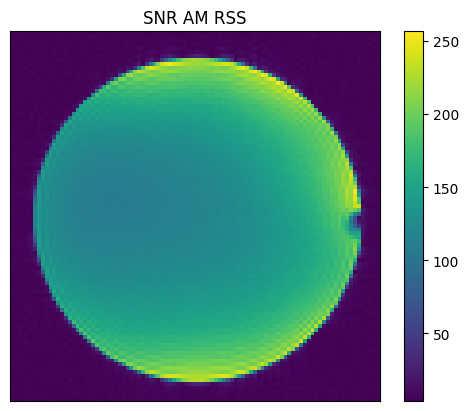

In [3]:

# Instantate the class
R=mroAnalyticalMethodRSS()
R.setNoiseKSpace(N)
R.setSignalKSpace(S)
AM=R.getOutput()

plt.imshow(np.abs(AM))
plt.colorbar()
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.title('SNR AM RSS')



calculateCoilsSensitivityMask2D espirit
calculateCoilsSensitivityMask2D 

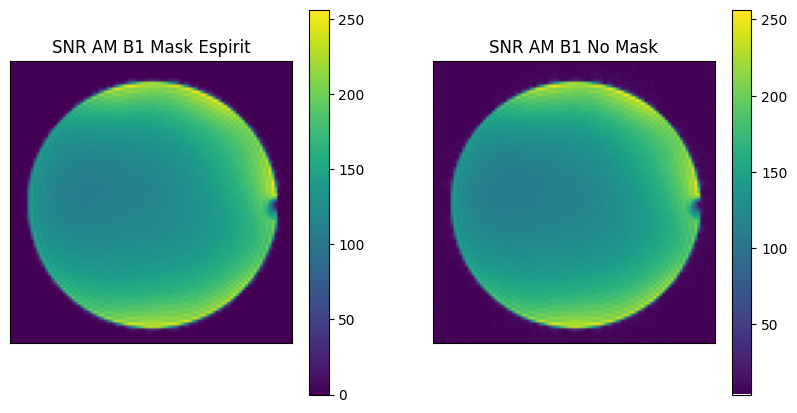

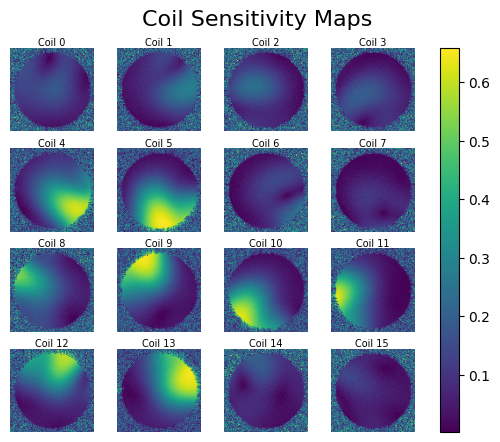

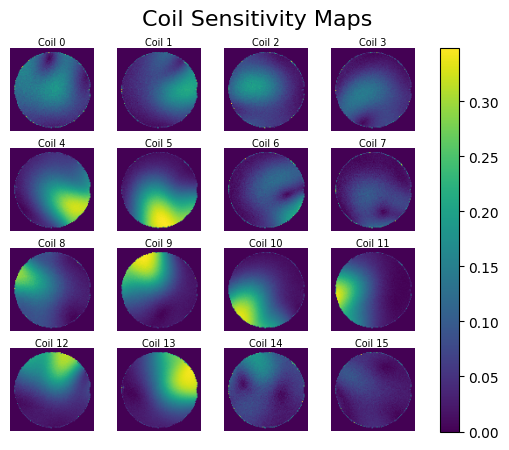

In [4]:
R1=mroAnalyticalMethodB1()
R1.setNoiseKSpace(N)
R1.setSignalKSpace(S)
R1.setReferenceKSpace(S)
R1.setMaskCoilSensitivityMatrixBasedOnEspirit()

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(np.abs(R1.getOutput()))
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.title('SNR AM B1 Mask Espirit')
plt.colorbar()

R2=mroAnalyticalMethodB1()
R2.setNoiseKSpace(N)
R2.setSignalKSpace(S)
R2.setReferenceKSpace(S)
R2.setNoMask()

plt.subplot(122)
plt.imshow(np.abs(R2.getOutput()))
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.title('SNR AM B1 No Mask')
plt.colorbar()
R2.plotCoilSensitivityMatrix('No Mask')
R1.plotCoilSensitivityMatrix('Espirit Mask')


# Pseudo Multiple Replicas

----
cmOutput created but Deprecated, use cmaws.cmrOutput instead
----


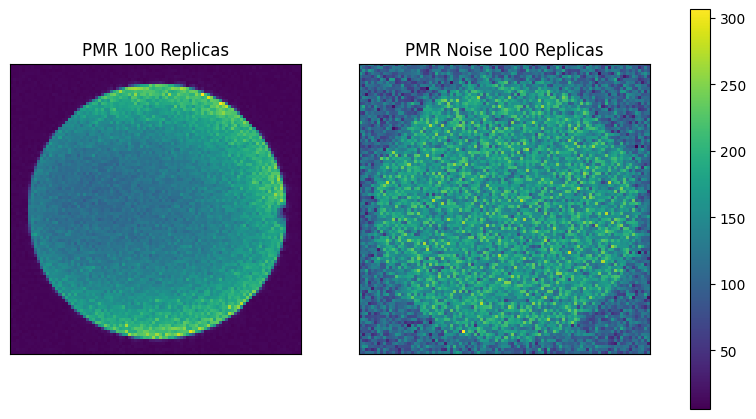

In [5]:
from cmtools.cm2D import cm2DReconRSS


L2=mroPseudoMultipleReplicas()
L=cm2DReconRSS()
L2.numberOfReplicas=100
L.setNoiseKSpace(N)
L.setSignalKSpace(S)
L2.reconstructor=L

PMR=L2.getOutput()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(np.abs(PMR))
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.title('PMR 100 Replicas')



plt.subplot(122)
plt.imshow(L2.getSNRDenumerator())
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.title('PMR Noise 100 Replicas')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.colorbar(plt.gcf().axes[0].images[0], ax=plt.gcf().axes)




----
cmOutput created but Deprecated, use cmaws.cmrOutput instead
----


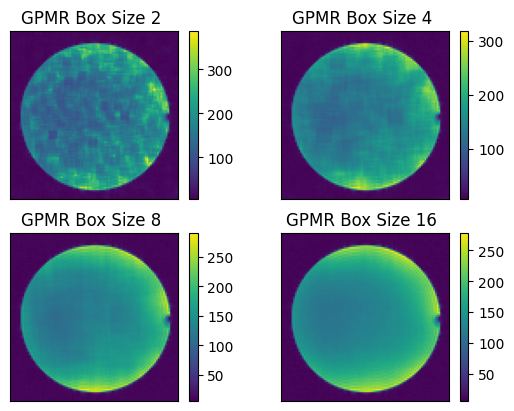

In [20]:


from mrotools.mro import mroGeneralizedPseudoMultipleReplicas
L2=mroGeneralizedPseudoMultipleReplicas()
L=cm2DReconRSS()
L2.numberOfReplicas=5

for i,b in enumerate([2,4,8,16]):
  L2.boxSize = b
  L.setNoiseKSpace(N)
  L.setSignalKSpace(S)
  L2.reconstructor=L
  GPMR_=L2.getOutput()
  plt.subplot(2,2,i+1)
  plt.imshow(np.abs(GPMR_))
  plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
  plt.title(f'GPMR Box Size {b} ')
  plt.colorbar()

GPMR=GPMR_






In [10]:
import os

if not os.path.exists('KS.npz'):
  !wget https://cmrpeople.s3.us-east-1.amazonaws.com/KS.npz

--2025-12-06 20:31:06--  https://cmrpeople.s3.us-east-1.amazonaws.com/KS.npz
Resolving cmrpeople.s3.us-east-1.amazonaws.com (cmrpeople.s3.us-east-1.amazonaws.com)... 52.217.202.82, 52.216.57.250, 52.217.122.50, ...
Connecting to cmrpeople.s3.us-east-1.amazonaws.com (cmrpeople.s3.us-east-1.amazonaws.com)|52.217.202.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110411990 (105M) [binary/octet-stream]
Saving to: ‘KS.npz’

KS.npz              100%[===================>] 105.30M  30.3MB/s    in 3.5s    

2025-12-06 20:31:09 (30.3 MB/s) - ‘KS.npz’ saved [110411990/110411990]



----
cmOutput created but Deprecated, use cmaws.cmrOutput instead
----


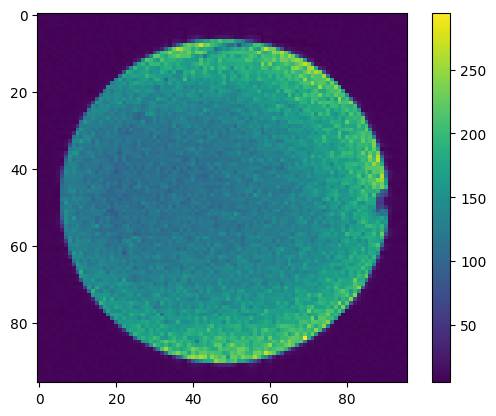

In [14]:
from mrotools.mro import mroMultipleReplicas


MREP=mroMultipleReplicas()
K_all = np.load("KS.npz")["signal"]  # (R, Nx, Ny, Nc)

recon=cm2DReconRSS()
recon.setNoiseKSpace(N)

MREP.setReconstructor(recon)
for r in K_all:
  MREP.add2DKspace(r)

MR=MREP.getOutput()
plt.imshow(np.abs(MR))
plt.colorbar()



Text(0.5, 1.0, 'Multiple Replicas')

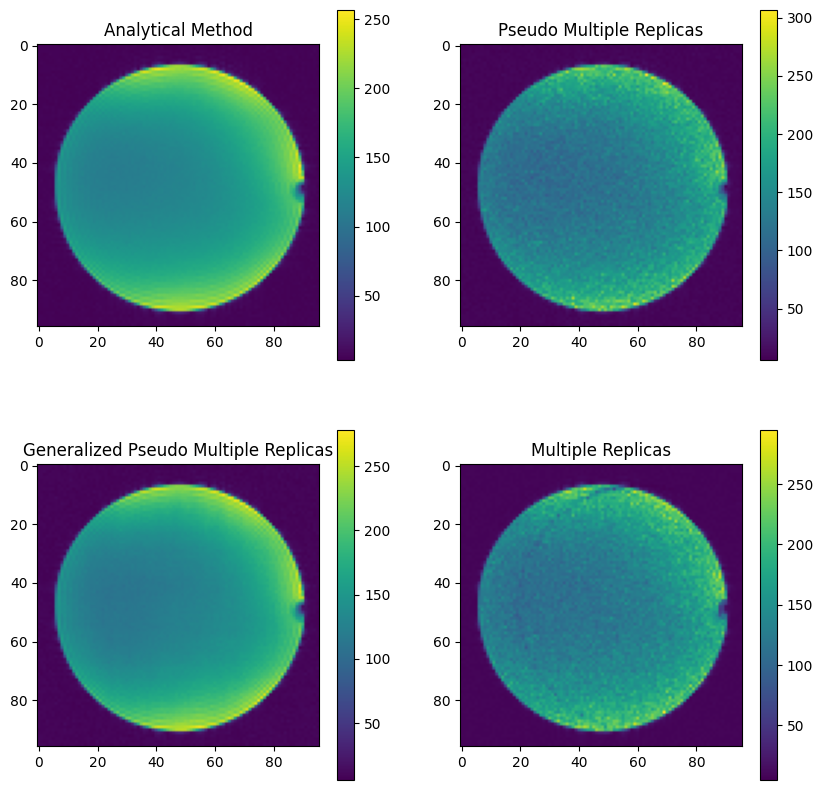

In [21]:

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(np.abs(AM))
plt.title('Analytical Method')
plt.colorbar()
plt.subplot(222)
plt.imshow(np.abs(PMR))
plt.title('Pseudo Multiple Replicas')
plt.colorbar()
plt.subplot(223)
plt.imshow(np.abs(GPMR))
plt.colorbar()
plt.title('Generalized Pseudo Multiple Replicas')
plt.subplot(224)
plt.imshow(np.abs(MR))
plt.colorbar()
plt.title('Multiple Replicas')

